In [1]:
%matplotlib inline

from database.DataBaseModels import *
from source.ArticleParser import ArticleParser
from itertools import combinations
from collections import Counter

import pygal
import operator
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
total_digraph = nx.MultiDiGraph()


for citation in db.Citation.select():
    if citation.article_id.title != 'None' and citation.cited_by.title != 'None':
        total_digraph.add_edge(citation.cited_by, citation.article_id)
        
total_digraph.remove_edges_from([edge for edge in total_digraph.selfloop_edges()])

while True:
    try:
        for edge in nx.find_cycle(total_digraph):
            total_digraph.remove_edge(edge[0], edge[1])
    except:
        break
    
        
weakly_subgraphs_list = list(nx.weakly_connected_component_subgraphs(total_digraph))
strongly_subgraphs_list = list(nx.strongly_connected_component_subgraphs(total_digraph))

print('Number of nodes: {0}'.format(len(total_digraph.nodes)),
      'Number of edges: {0}'.format(len(total_digraph.edges)),
      'Number of weakly connected subgraphs: {0}'.format(len(weakly_subgraphs_list)),
      'Number of strongly connected subgraphs: {0}'.format(len(strongly_subgraphs_list)),
       sep='\n')

Number of nodes: 3890
Number of edges: 14890
Number of weakly connected subgraphs: 74
Number of strongly connected subgraphs: 3890


In [ ]:
root_list = []
keywords = []
citation_factor = 10

for node in total_digraph.nodes:
    if not list(total_digraph.successors(node)):
        if len(list(total_digraph.predecessors(node))) == citation_factor:
            root_list.append(node)
            print(node.title)

for root in root_list:
    parser = ArticleParser()
    keywords.append(parser.parse(root.article_id)['keywords'])

In [4]:
for ls in keywords:
    for keyword in ls:
        print(keyword, end=', ')
    print()

NameError: name 'keywords' is not defined

In [5]:
wcc_graph = weakly_subgraphs_list[0]
sources_list = []
sinks_list = []

for node in wcc_graph.nodes:
    if len(list(wcc_graph.successors(node))) == 0:
        sinks_list.append(node)
    elif len(list(wcc_graph.predecessors(node))) == 0:
        sources_list.append(node)

In [20]:
def get_number_of_article_citations(article):
    return len(article.article__citation_article_id)

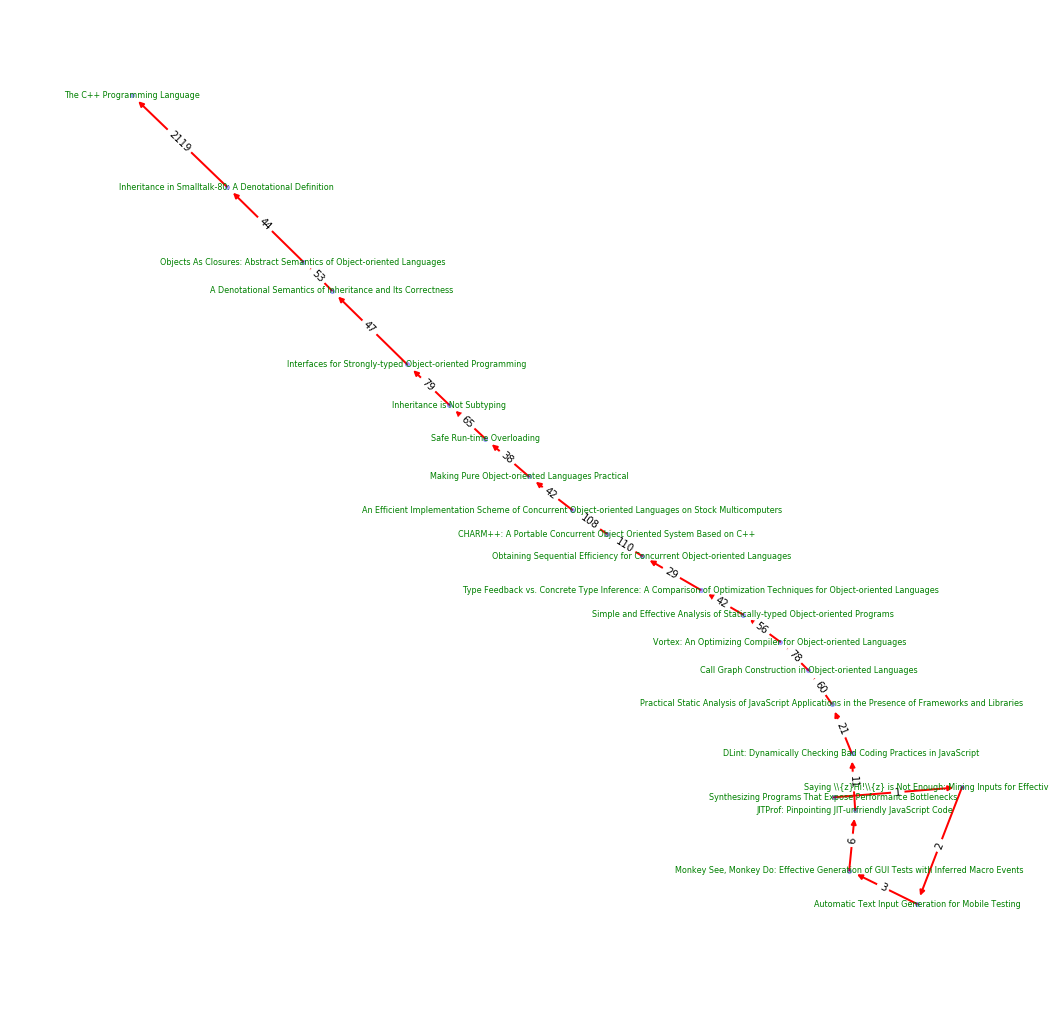

In [21]:
NODE_SIZE = 16
WIDTH = 2
NODE_COLOR = 'blue'
EDGE_COLOR = 'red'

graph = nx.DiGraph()
labels = {}
main_path = nx.dag_longest_path(wcc_graph)
for article in main_path:
    labels[article] = article.title
graph.add_path(main_path)

for edge in graph.edges:
    graph[edge[0]][edge[1]]['weight'] = (get_number_of_article_citations(edge[0]) + get_number_of_article_citations(edge[1])) // 2

weight_labels = nx.get_edge_attributes(graph, 'weight')
    
graph_pos = nx.spring_layout(graph)

plt.figure(figsize=(18,18))

nx.draw_networkx_nodes(graph,
                      graph_pos,
                      node_size=NODE_SIZE,
                      node_color=NODE_COLOR,
                      alpha=0.3)
nx.draw_networkx_edges(graph,
                      graph_pos,
                      edge_color=EDGE_COLOR,
                      width=WIDTH)
nx.draw_networkx_labels(graph,
                       graph_pos,
                       labels=labels,
                       font_size=8,
                       font_family='sans-serif',
                       font_color='green')
nx.draw_networkx_edge_labels(graph,
                            graph_pos,
                            edge_labels=weight_labels)

plt.axis('off')
plt.savefig("visualization/main_path.pdf")
plt.show()

30.0


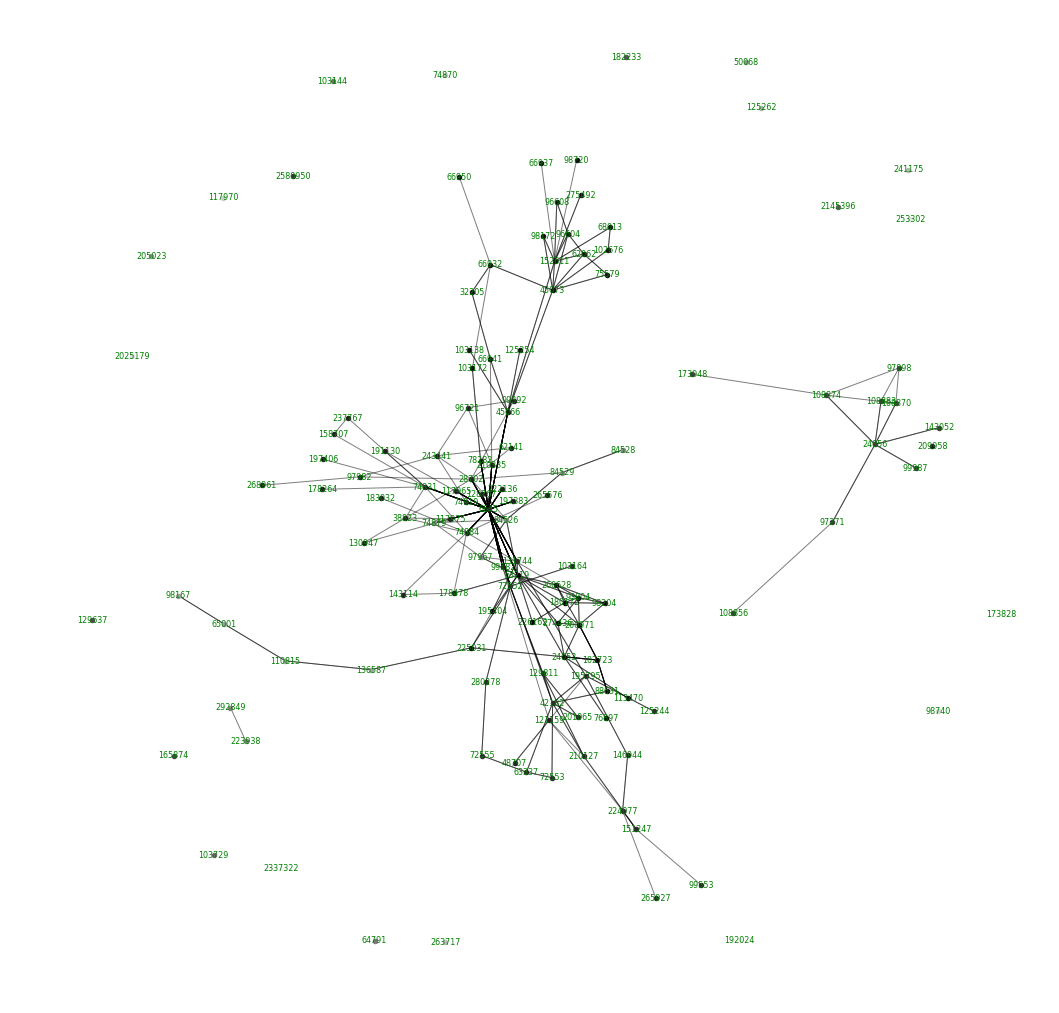

In [101]:
subundigraph = nx.to_undirected(wcc_graph)
graph = nx.MultiGraph()

for edge in subundigraph.edges:
    graph.add_edge(edge[0], edge[1])

node_list_removing = []  
    
for node in graph.nodes:
    if get_number_of_article_citations(node) < 100:
        node_list_removing.append(node)

graph.remove_nodes_from(node_list_removing)

partition = community.best_partition(graph)

plt.figure(figsize=(18,18))

size = float(len(set(partition.values())))
pos = nx.spring_layout(graph, k=0.2)

count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    dict_labels = {node:node.article_id for node in list_nodes}
    
    nx.draw_networkx_nodes(graph,
                           pos,
                           list_nodes,
                           node_size = 20,
                           node_color = str(count / size))
    nx.draw_networkx_labels(graph,
                           pos,
                           labels=dict_labels,
                           font_size=8,
                           font_family='sans-serif',
                           font_color='green')

nx.draw_networkx_edges(graph,pos, alpha=0.5)
plt.axis('off')
plt.savefig("visualization/community_detection_algorithms.pdf")
plt.show()